## Protecting Digital India: Predictive Modeling for UPI Fraud Prevention

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
from warnings import filterwarnings
filterwarnings('ignore')

### Step 1 : Data Loading & Initial Observations

In [2]:
df = pd.read_csv(r"D:\9. Self Projects\4. Econometrics Project\Regression Model Data\UPI Fraud data 7.0.csv")
df.tail(2)

,TransactionID,UserID,Amount,Timestamp,MerchantCategory,TransactionType,DeviceID,IPAddress,Latitude,Longitude,AvgTransactionAmount,TransactionFrequency,UnusualLocation,UnusualAmount,NewDevice,FailedAttempts,FraudFlag,PhoneNumber,BankName
1997,2.800000e+11,d25ef3fc-58c3-4f38-91ab-79646bdc1efd,584.73,09-07-2024 23:22,Restaurants,P2M,bd6e3677-38b7-4a80-ac3e-1a9098da3526,25.103.69.73,-1.788853,-53.000688,4115.97,1/day,False,False,True,0,0,9.219632e+08,Kotak Mahindra Bank
1998,2.810000e+11,a8c97179-7b14-47cb-8547-f7f56dd7bb54,9646.51,20-06-2024 22:46,Travel,P2M,cb31ffdf-9bf1-45d2-9647-49d8cb609f73,220.119.79.197,19.728980,133.053573,2822.32,1/day,False,False,False,2,0,9.355771e+09,ICICI Bank


In [3]:
df.shape               #To see number of column and rows

(1999, 19)

In [4]:
df.dtypes              # To see data types

TransactionID           float64
UserID                   object
Amount                  float64
Timestamp                object
MerchantCategory         object
TransactionType          object
DeviceID                 object
IPAddress                object
Latitude                float64
Longitude               float64
AvgTransactionAmount    float64
TransactionFrequency     object
UnusualLocation            bool
UnusualAmount              bool
NewDevice                  bool
FailedAttempts            int64
FraudFlag                 int64
PhoneNumber             float64
BankName                 object
dtype: object

In [5]:
df.nunique()             # To see no. of unique data

TransactionID            182
UserID                  1999
Amount                  1997
Timestamp               1986
MerchantCategory           7
TransactionType            2
DeviceID                1999
IPAddress               1999
Latitude                1999
Longitude               1999
AvgTransactionAmount    1993
TransactionFrequency       3
UnusualLocation            2
UnusualAmount              2
NewDevice                  2
FailedAttempts             5
FraudFlag                  2
PhoneNumber             1345
BankName                   6
dtype: int64

In [6]:
print( f' - Types of Merchant Payments : {df['MerchantCategory'].unique()}')
print( f' - Transactional Frequency : {df['TransactionFrequency'].unique()}')
print( f' - Name of the Banks : {df['BankName'].unique()}')

 - Types of Merchant Payments : ['Travel' 'Restaurants' 'Clothing' 'Entertainment' 'Electronics'
 'Groceries' 'Utilities']
 - Transactional Frequency : ['1/day' '5/day' '3/day']
 - Name of the Banks : ['ICICI Bank' 'Kotak Mahindra Bank' 'State Bank of India' 'HDFC Bank'
 'Axis Bank' 'Bank of Baroda']


In [7]:
df.duplicated().sum()    # To see no. of duplicate values

0

In [8]:
df.isnull().sum()        # To see no. of null values in the dataset

TransactionID           0
UserID                  0
Amount                  0
Timestamp               0
MerchantCategory        0
TransactionType         0
DeviceID                0
IPAddress               0
Latitude                0
Longitude               0
AvgTransactionAmount    0
TransactionFrequency    0
UnusualLocation         0
UnusualAmount           0
NewDevice               0
FailedAttempts          0
FraudFlag               0
PhoneNumber             0
BankName                0
dtype: int64

###### As there is no null values, imputation is not needed.

In [9]:
df['FraudFlag'].value_counts()

FraudFlag
0    1238
1     761
Name: count, dtype: int64

### Step 2 : Data Pre-processing

In [10]:
# Converting timestamp, from object to datetime 
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)


In [11]:
# Adding few cols which can help in prediction

df['DayOfWeek'] = df['Timestamp'].dt.dayofweek                          # 0 = Monday & 6 = Sunday
print(f'No. of unique days : {df['DayOfWeek'].nunique()}')

df['IsNightTime'] = df['Timestamp'].dt.hour.between(22, 6).astype(int)  # 10 PM to 6 AM
print(f'No. of Diff time of the day : {df['IsNightTime'].nunique()}')

No. of unique days : 7
No. of Diff time of the day : 1


###### As there is only one time of data i.e., in the day time data, no night time payment is here, the col "IsNightTime" is not needed. Later gonna drop it.

In [12]:
# One hot encoding : converting categorical variables into a numerical
df = pd.get_dummies(df, columns=['TransactionType'], prefix = 'TransType', drop_first=False)

###### Here is more categorical data like BankName, MerchantCategory...later based on important will change.

In [13]:
# Converting all booleans to int
bool_cols = ['UnusualLocation', 'UnusualAmount', 'NewDevice', 'FraudFlag', 'TransType_P2M', 'TransType_P2P']
df[bool_cols] = df[bool_cols].astype(int)

In [14]:
# Converting object to int
df['FreqPerDay'] = df['TransactionFrequency'].str.extract('(\d+\.?\d*)').astype(float)    # First converted into float
df['FreqPerDay'] = df['FreqPerDay'].astype(int)

###### First extracted the numeric part, as the data i.e, 5/day is not fully numeric, so directly obj to numeric is tough code, so I did it.

In [15]:
# Droping the unnecessary cols 
df = df.drop(columns=['TransactionID', 'UserID', 'Timestamp', 'DeviceID', 'IPAddress', 'PhoneNumber', 'IsNightTime', 'TransactionFrequency'])

In [16]:
from sklearn.cluster import KMeans  # Already installed with scikit-learn

# Create location clusters
coords = df[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=30, random_state=42)
df['LocationCluster'] = kmeans.fit_predict(coords)

# Create fraud-risk features
cluster_fraud_rate = df.groupby('LocationCluster')['FraudFlag'].mean()
df['LocationRiskScore'] = df['LocationCluster'].map(cluster_fraud_rate)

# Drop original columns
df_new = df.drop(['Latitude', 'Longitude', 'LocationCluster'], axis=1)

###### K-Means groups transactions into location clusters to identify regions with similar fraud patterns. Then, a LocationRiskScore is assigned to each transaction based on the average fraud rate of its cluster, replacing raw coordinates for better model insight. As Lat, Lang directly can't be use properly.

### Step 3 : Exploratory Data Analysis (EDA)

In [17]:
df_new.describe()

,Amount,AvgTransactionAmount,UnusualLocation,UnusualAmount,NewDevice,FailedAttempts,FraudFlag,DayOfWeek,TransType_P2M,TransType_P2P,FreqPerDay,LocationRiskScore
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,4906.684882,4963.191686,0.515258,0.501251,0.503252,2.040020,0.380690,2.954977,0.504752,0.495248,3.062031,0.380690
std,2864.132746,2886.330035,0.499892,0.500124,0.500115,1.418242,0.485678,1.980883,0.500103,0.500103,1.636714,0.046185
min,5.810000,1.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.281250
25%,2430.320000,2473.645000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.342466
50%,4879.840000,4955.810000,1.000000,1.000000,1.000000,2.000000,0.000000,3.000000,1.000000,0.000000,3.000000,0.390625
75%,7444.490000,7377.255000,1.000000,1.000000,1.000000,3.000000,1.000000,5.000000,1.000000,1.000000,5.000000,0.416667
max,9965.900000,9994.770000,1.000000,1.000000,1.000000,4.000000,1.000000,6.000000,1.000000,1.000000,5.000000,0.462500


###### - No significant Outliers are seen as the difference between mean and median are very less. Min location risk is 6% and max is 12% ( now by using location cluster I can find which location have the highest fraud risk) etc.

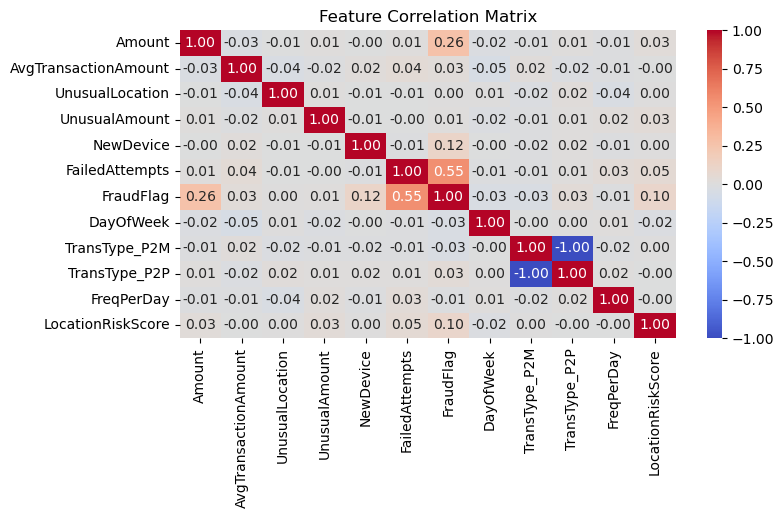

In [18]:
# Checking corrlation btw variables using Heatmap
corr = df_new.corr(numeric_only=True)
plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

###### - There is no severe Multicollinearity among the features.

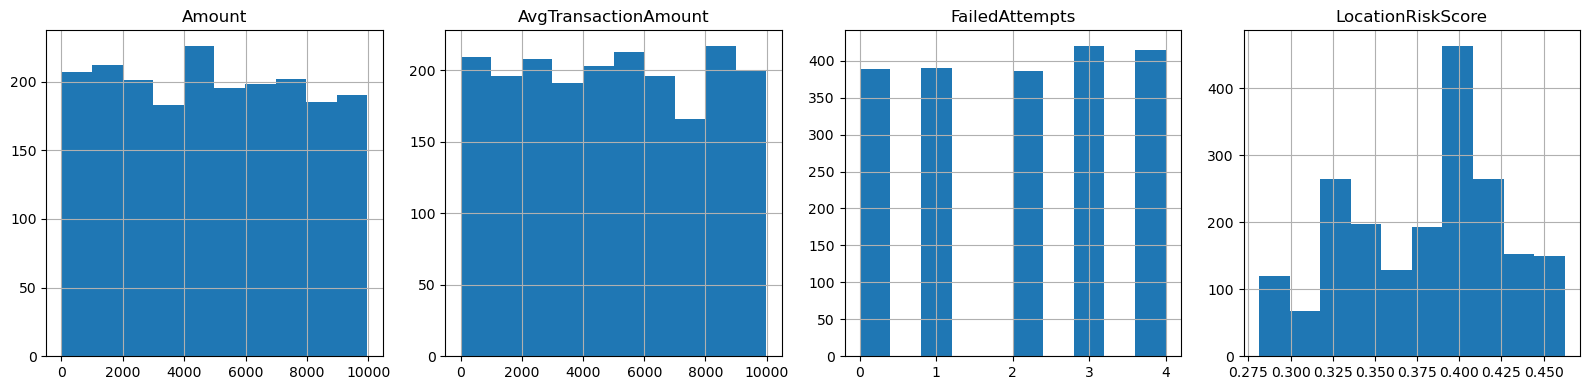

In [19]:
# Histogram of the dataset
df_new[["Amount", "AvgTransactionAmount", "FailedAttempts", "LocationRiskScore"]].hist(figsize=(16,4), layout=(1, 4))
plt.tight_layout()
plt.show()

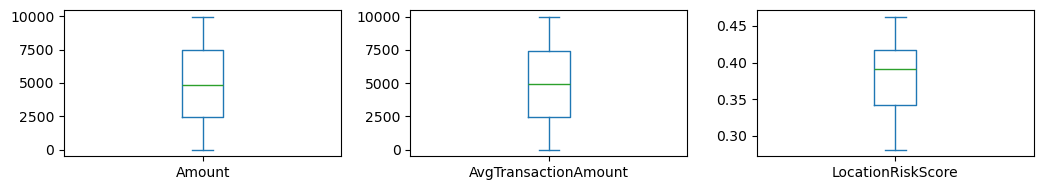

In [20]:
# Boxplot of the dataset
df_new[["Amount", "AvgTransactionAmount", "LocationRiskScore"]].plot(
    kind='box', 
    figsize=(14, 2),
    subplots=True,
    layout=(1, 4)
)
plt.tight_layout()
plt.show()

###### - There is no potential Outliers. But 'LocationRiskScore' plot showing the distribution is negatively skewed (left-skewed), most values are concentrated at higher risk scores ( most locations have higher risk scores and fewer locations have very low risk scores ). Means the data is taken from riskier zone specially.

### Step 4 : Model Creation ( Logistic Regression )

#### Step by step Logit Regression 

#### Step 1. Checking Assumptions

##### 1. Checking Multicollinearity

In [21]:
# Checking Multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm

X = df[['Amount', 'AvgTransactionAmount', 'UnusualLocation', 'UnusualAmount', 'NewDevice', 'FailedAttempts', 
             'DayOfWeek', 'TransType_P2M', 'FreqPerDay', 'LocationRiskScore']]

X = sm.add_constant(X)  # add intercept

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


                 Feature        VIF
0                  const  85.880154
1                 Amount   1.002490
2   AvgTransactionAmount   1.007585
3        UnusualLocation   1.003461
4          UnusualAmount   1.002667
5              NewDevice   1.001081
6         FailedAttempts   1.006515
7              DayOfWeek   1.003790
8          TransType_P2M   1.001819
9             FreqPerDay   1.004015
10     LocationRiskScore   1.004610


###### Here constant have multicolinearity, this means my constant is nearly a linear combination of my other features

In [22]:
# Standardize the features to reduce multicollinearity
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=['const']))

# Add constant back
import statsmodels.api as sm
X_scaled = sm.add_constant(X_scaled)

# Recalculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = ['const'] + list(X.columns[1:])
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data)

                 Feature       VIF
0                  const  1.000000
1                 Amount  1.002490
2   AvgTransactionAmount  1.007585
3        UnusualLocation  1.003461
4          UnusualAmount  1.002667
5              NewDevice  1.001081
6         FailedAttempts  1.006515
7              DayOfWeek  1.003790
8          TransType_P2M  1.001819
9             FreqPerDay  1.004015
10     LocationRiskScore  1.004610


##### 2. Checking Linearity

In [23]:
# To check Linearity in the model
print("BOX-TIDWELL TEST - Individual Variable Testing")
print("="*60)

# Define continuous and categorical variables
continuous_vars = ['Amount', 'AvgTransactionAmount', 'FailedAttempts', 'FreqPerDay', 'LocationRiskScore']
categorical_vars = ['UnusualLocation', 'UnusualAmount', 'NewDevice', 'DayOfWeek', 'TransType_P2M']

# Define dependent and independent variables
y = df['FraudFlag']   # your target variable (0 or 1)
X = df[continuous_vars + categorical_vars]


for var in continuous_vars:
    # Create dataset with only this variable's interaction
    X_test = X[continuous_vars + categorical_vars].copy()
    X_test[f'{var}_log'] = X_test[var] * np.log(X_test[var] + 1e-5)
    X_test = sm.add_constant(X_test)
    
    # Fit model
    model = sm.Logit(y, X_test).fit(disp=0)
    
    # Get p-value for interaction term
    p_val = model.pvalues[f'{var}_log']
    
    print(f"{var:25s} | p-value: {p_val:.4f} | {'✗ Non-linear' if p_val < 0.05 else '✓ Linear'}")

BOX-TIDWELL TEST - Individual Variable Testing
Amount                    | p-value: 0.2565 | ✓ Linear
AvgTransactionAmount      | p-value: 0.9652 | ✓ Linear
FailedAttempts            | p-value: 0.0000 | ✗ Non-linear
FreqPerDay                | p-value: 0.3493 | ✓ Linear
LocationRiskScore         | p-value: 0.9629 | ✓ Linear


#### Step 2. Fit Logistic Regression model

In [24]:
# logistic regression model with regularization
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Example data
X = df[['Amount', 'AvgTransactionAmount', 'FailedAttempts', 'FreqPerDay', 'LocationRiskScore']]  # predictors
y = df['FraudFlag']  # target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Logistic Regression with L2 regularization (Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42)
logreg_l2.fit(X_train_scaled, y_train)

# Predictions
y_pred = logreg_l2.predict(X_test_scaled)
y_prob = logreg_l2.predict_proba(X_test_scaled)[:,1]

# Coefficients
print("Coefficients:", logreg_l2.coef_)


Coefficients: [[ 0.82585942  0.07914134  1.53489634 -0.04220068  0.16905196]]


In [25]:
# L1 Regularization (Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
logreg_l1.fit(X_train_scaled, y_train)
print("L1 Coefficients:", logreg_l1.coef_)


L1 Coefficients: [[ 0.82563973  0.07550415  1.53729787 -0.03852039  0.16572435]]


In [26]:
# ElasticNet Regularization
logreg_en = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, random_state=42)
logreg_en.fit(X_train_scaled, y_train)
print("ElasticNet Coefficients:", logreg_en.coef_)


ElasticNet Coefficients: [[ 0.82655853  0.07737181  1.537954   -0.04035897  0.1676529 ]]


#### 3. Model Significance

In [27]:
import statsmodels.api as sm

# Continuous variables only
continuous_vars = ['Amount', 'AvgTransactionAmount', 'FailedAttempts', 'FreqPerDay', 'LocationRiskScore']

# Create X with constant
X_model = sm.add_constant(X[continuous_vars])

# Fit logistic regression
logit_model = sm.Logit(y, X_model).fit()
print(logit_model.summary())

# --- Model significance ---

# 1. Likelihood Ratio Test p-value
llr_pvalue = logit_model.llr_pvalue
print("\nLikelihood Ratio Test p-value:", llr_pvalue)
if llr_pvalue < 0.05:
    print("=> Model is statistically significant.")
else:
    print("=> Model is NOT statistically significant.")

# 2. Pseudo R-squared (McFadden)
pseudo_r2 = logit_model.prsquared
print("Pseudo R-squared (McFadden):", pseudo_r2)

# 3. Significant variables (p < 0.05)
significant_vars = logit_model.pvalues[logit_model.pvalues < 0.05].index.tolist()
print("Significant variables:", significant_vars)


Optimization terminated successfully.
         Current function value: 0.442629
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              FraudFlag   No. Observations:                 1999
Model:                          Logit   Df Residuals:                     1993
Method:                           MLE   Df Model:                            5
Date:                Tue, 28 Oct 2025   Pseudo R-squ.:                  0.3338
Time:                        15:13:25   Log-Likelihood:                -884.81
converged:                       True   LL-Null:                       -1328.1
Covariance Type:            nonrobust   LLR p-value:                2.066e-189
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.1679      0.571    -10.809      0.000      -7.286      -5.049

##### - Now from here I can find Hierarchy of Significant Attributes & Interpretation of Coefficients.

#### 4. Model Performance

In [28]:
# Evaluating model performance
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

y_pred = logreg_l2.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.83
ROC-AUC: 0.8979183450713376
Confusion Matrix:
 [[203  36]
 [ 32 129]]


In [29]:
# Classification report
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Predict class labels
y_pred = logreg_l2.predict(X_test_scaled)

# Predict probabilities for ROC-AUC
y_prob = logreg_l2.predict_proba(X_test_scaled)[:,1]

# Classification report: precision, recall, f1-score
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86       239
           1       0.78      0.80      0.79       161

    accuracy                           0.83       400
   macro avg       0.82      0.83      0.82       400
weighted avg       0.83      0.83      0.83       400



#### 5. Examine Significance of Individual Predictors

In [30]:
# Coefficient table
import pandas as pd
import statsmodels.api as sm

# Fit the logistic regression model (example with continuous variables)
continuous_vars = ['Amount', 'AvgTransactionAmount', 'FailedAttempts', 'FreqPerDay', 'LocationRiskScore']
X_model = sm.add_constant(X[continuous_vars])
logit_model = sm.Logit(y, X_model).fit()

# Extract coefficients table
coef_table = pd.DataFrame({
    'coef': logit_model.params,
    'std err': logit_model.bse,
    'z': logit_model.tvalues,
    'P>|z|': logit_model.pvalues,
    '0.025': logit_model.conf_int()[0],
    '0.975': logit_model.conf_int()[1]
})

print(coef_table)


Optimization terminated successfully.
         Current function value: 0.442629
         Iterations 7
                          coef   std err          z          P>|z|     0.025  \
const                -6.167915  0.570653 -10.808527   3.136646e-27 -7.286373   
Amount                0.000294  0.000023  12.990614   1.383137e-38  0.000250   
AvgTransactionAmount  0.000013  0.000020   0.623308   5.330819e-01 -0.000027   
FailedAttempts        1.156062  0.053894  21.450744  4.494081e-102  1.050432   
FreqPerDay           -0.041801  0.036200  -1.154734   2.481994e-01 -0.112752   
LocationRiskScore     4.250318  1.299527   3.270666   1.072947e-03  1.703292   

                         0.975  
const                -5.049456  
Amount                0.000339  
AvgTransactionAmount  0.000053  
FailedAttempts        1.261692  
FreqPerDay            0.029149  
LocationRiskScore     6.797344  


In [31]:
# Converting coefficients to odds ratios
import numpy as np

coefficients = [0.82585942, 0.07914134, 1.53489634, -0.04220068, 0.16905196]
odds_ratios = np.exp(coefficients)
print("Odds Ratios:", odds_ratios)


Odds Ratios: [2.2838427  1.08235729 4.64084444 0.95867737 1.18418167]


#### 6. Prepare Model for Prediction

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=500))
])

pipeline.fit(X_train, y_train)

# Save the full pipeline
joblib.dump(pipeline, 'UPI_Fraud_Pipeline.pkl')
print("✅ Pipeline saved successfully!")


✅ Pipeline saved successfully!


### Step 5 : Predicting Fraud case on New dataset

In [33]:
# Importing new dataset
df_new= pd.read_excel(r"D:\9. Self Projects\4. Econometrics Project\Regression Model Data\UPI Fraud model testing data.xlsx")
df_new.head(2)

,UserID,Amount,AvgTransactionAmount,UnusualLocation,UnusualAmount,NewDevice,FailedAttempts,FraudFlag,DayOfWeek,TransType_P2M,TransType_P2P,FreqPerDay,LocationRiskScore
0,dda7766f-66c2-4a60-a249-3751456e5c08,8970.64,4289.17,0,1,1,1,0,0,1,0,3,0.10101
1,60e5814a-1ed6-465a-ad86-a37e77a6afbd,8970.25,3737.94,1,1,0,2,0,4,1,0,5,0.09375


In [34]:
# To explicitly define which columns the model should learn from
cols = ['Amount', 'AvgTransactionAmount', 'FailedAttempts', 'FreqPerDay', 'LocationRiskScore']

In [35]:
# Use the same feature columns as training
X_new = df_new[cols]

# Get fraud probabilities
df_new['Fraud chance'] = pipeline.predict_proba(X_new)[:, 1]   # Here calling that pipeline saved earlier of my trained model's.

# Create an alert column for high-risk users
df_new['Alert'] = df_new['Fraud chance'] > 0.7

# Filter those with high fraud chance
at_risk = df_new[df_new['Alert']]

# To View result
print(at_risk[['UserID', 'Fraud chance']])
print(f"Total High-Risk Users: {len(at_risk)}")

                                   UserID  Fraud chance
4    02b41d0d-8a71-467e-bef2-7117995b1269      0.805639
9    51b7036e-9629-492b-93c1-5e17faea82ea      0.809483
17   e1ec69a9-bfcb-4d75-84d5-83b25e13348b      0.798573
19   1ec48edb-5c8f-4b83-9ff6-b72bdaeb1f7e      0.776341
37   100e566b-1cd3-4f8b-b342-80ecf244958d      0.812341
..                                    ...           ...
978  3840c4db-6022-4da2-b716-49973f15a230      0.770021
983  a383e348-2c54-44cd-a756-07526245ea53      0.742138
990  8bdcdf5a-ba06-405f-a4ab-2ba3250dc10a      0.747487
994  edb43a1a-6082-4bc5-91b6-fa11bc537dfa      0.750198
995  5b0b0b14-aa33-4f07-a6c3-c41a18ebfa50      0.796674

[170 rows x 2 columns]
Total High-Risk Users: 170


In [36]:
at_risk[['UserID', 'Fraud chance', 'Alert']].head(7)

,UserID,Fraud chance,Alert
4,02b41d0d-8a71-467e-bef2-7117995b1269,0.805639,True
9,51b7036e-9629-492b-93c1-5e17faea82ea,0.809483,True
17,e1ec69a9-bfcb-4d75-84d5-83b25e13348b,0.798573,True
19,1ec48edb-5c8f-4b83-9ff6-b72bdaeb1f7e,0.776341,True
37,100e566b-1cd3-4f8b-b342-80ecf244958d,0.812341,True
47,f0c756ea-8e1d-4d99-8bbb-10a9f151c473,0.803633,True
53,f9e9bd80-8d3c-49e5-9ae8-0602218ac9b2,0.813506,True


### Extra Analysis -

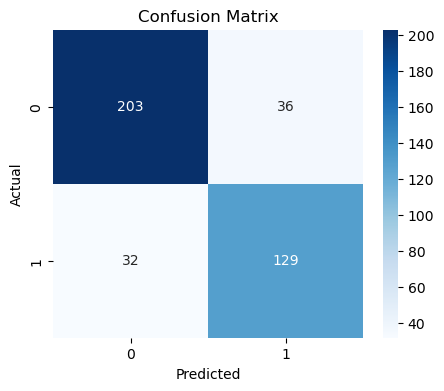

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###### 1) True -ve (203) : correctly predicted class 0.   2) False +ve (36) : Incorrectly predicted class 1 (Type I error).     3) False -ve (32) : Incorrectly predicted class 0 (Type II error).    4) True +ve (129) : Correctly predicted class 1.

In [49]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for a clean table
cm_df = pd.DataFrame(cm, 
                     index=['Actual Legit', 'Actual Fraud'], 
                     columns=['Predicted Legit', 'Predicted Fraud'])

print(cm_df)

              Predicted Legit  Predicted Fraud
Actual Legit              203               36
Actual Fraud               32              129


In [56]:
from sklearn.metrics import roc_auc_score

roc_score = roc_auc_score(y_test, y_prob)
print("ROC–AUC Score:", roc_score)


ROC–AUC Score: 0.8979183450713376


###### This means my model has very strong discriminative power to distinguish between fraudulent and non-fraudulent users.

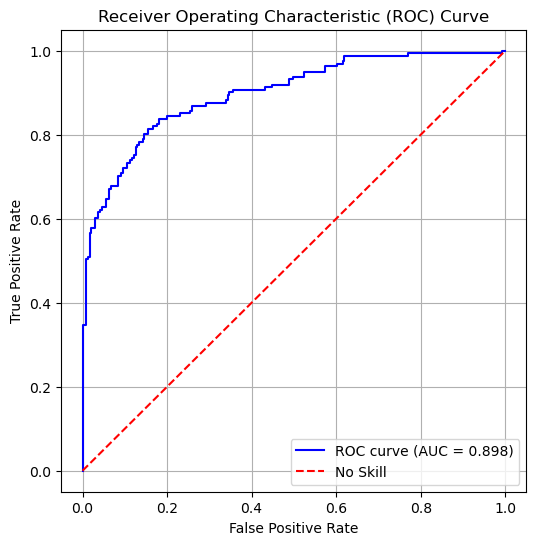

In [57]:
# ROC Curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute the False Positive Rate (FPR), True Positive Rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_score:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
# Get feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg_l2.coef_[0]
})

# Convert coefficients to absolute values for importance ranking
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])

# Sort by importance (descending)
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)


                Feature  Coefficient  Importance
2        FailedAttempts     1.534896    1.534896
0                Amount     0.825859    0.825859
4     LocationRiskScore     0.169052    0.169052
1  AvgTransactionAmount     0.079141    0.079141
3            FreqPerDay    -0.042201    0.042201


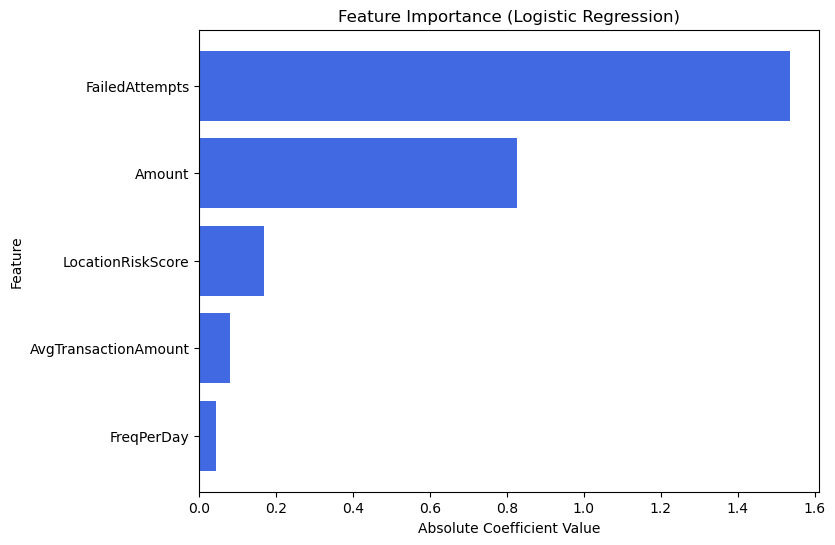

In [60]:
# Visualization of feature importance
plt.figure(figsize=(8,6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='royalblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()
plt.show()
